In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cobyla

def gpr_predict(xB, yB, xPred=None, plot=True):
    # Função objetivo: log-verossimilhança negativa
    def objective(x):
        mxB = x[0]*xB**2 + x[1]*xB + x[2] + x[6]*xB**3 + x[7]*xB**4
        KB = np.zeros((len(xB), len(xB)))
        for i in range(len(xB)):
            for j in range(i, len(xB)):
                noise = x[5]**2 if i == j else 0
                k = x[3]**2 * np.exp(-((xB[i] - xB[j])**2) / (2.0 * x[4]**2)) + noise**2
                KB[i, j] = k
                KB[j, i] = k
        KBinv = np.linalg.inv(KB)
        return -1 * (-0.5 * np.log(np.linalg.det(KB)) - 0.5 * (yB - mxB).T @ KBinv @ (yB - mxB) - len(xB)/2 * np.log(2*np.pi))

    # Restrições nos hiperparâmetros
    cons = [
        lambda x: x[4] - 1,       # ell > 1
        lambda x: 5 - x[4],       # ell < 5
        lambda x: x[3] - 0.8      # sigmaF2 > 0.8
    ]

    # Valores iniciais
    x0 = (0.1, 0.01, 0.01, 2.0, 1.0, 0.01, 0.01, 0.01)
    xopt = fmin_cobyla(objective, x0, cons, disp=0)

    # Hiperparâmetros aprendidos
    c4, c3, c2, c1, c0 = xopt[7], xopt[6], xopt[0], xopt[1], xopt[2]
    ell, sigmaF2, sigmaN2 = xopt[4], xopt[3], xopt[5]

    # Função de média e covariância
    def priormean(xin): return c4*xin**4 + c3*xin**3 + c2*xin**2 + c1*xin + c0
    def corrFunc(xa, xb): return sigmaF2**2 * np.exp(-((xa - xb)**2) / (2.0 * ell**2))

    mxB = priormean(xB)
    KB = np.zeros((len(xB), len(xB)))
    for i in range(len(xB)):
        for j in range(i, len(xB)):
            noise = sigmaN2**2 if i == j else 0
            k = corrFunc(xB[i], xB[j]) + noise**2
            KB[i, j] = k
            KB[j, i] = k
    KBinv = np.linalg.inv(KB)

    if xPred is None:
        xPred = np.arange(0, 10, 0.2)
    Ks = np.array([[corrFunc(xp, xb) for xb in xB] for xp in xPred])
    mus = priormean(xPred)
    ypred = mus + Ks @ KBinv @ (yB - mxB)
    Kss = np.array([[corrFunc(xPred[i], xPred[j]) + (sigmaN2 if i == j else 0) for j in range(len(xPred))] for i in range(len(xPred))])
    yvar = np.diag(Kss - Ks @ KBinv @ Ks.T)
    stds = np.sqrt(yvar)

    if plot:
        x = np.arange(0, 10, 0.1)
        mx = priormean(x)
        plt.figure(figsize=(12, 8))
        plt.plot(x, mx, label="mean $m(x)$")
        plt.plot(xB, yB, 'or', label="training data")
        plt.plot(xPred, ypred, '--g', label="predictions")
        plt.fill_between(xPred, ypred - 2*stds, ypred + 2*stds, color='gray', alpha=0.3, label="95% CI")
        plt.title("Gaussian Process Prediction with Bi-quadratic Mean")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.legend()
        plt.grid(True)
        plt.show()

    return xPred, ypred, stds

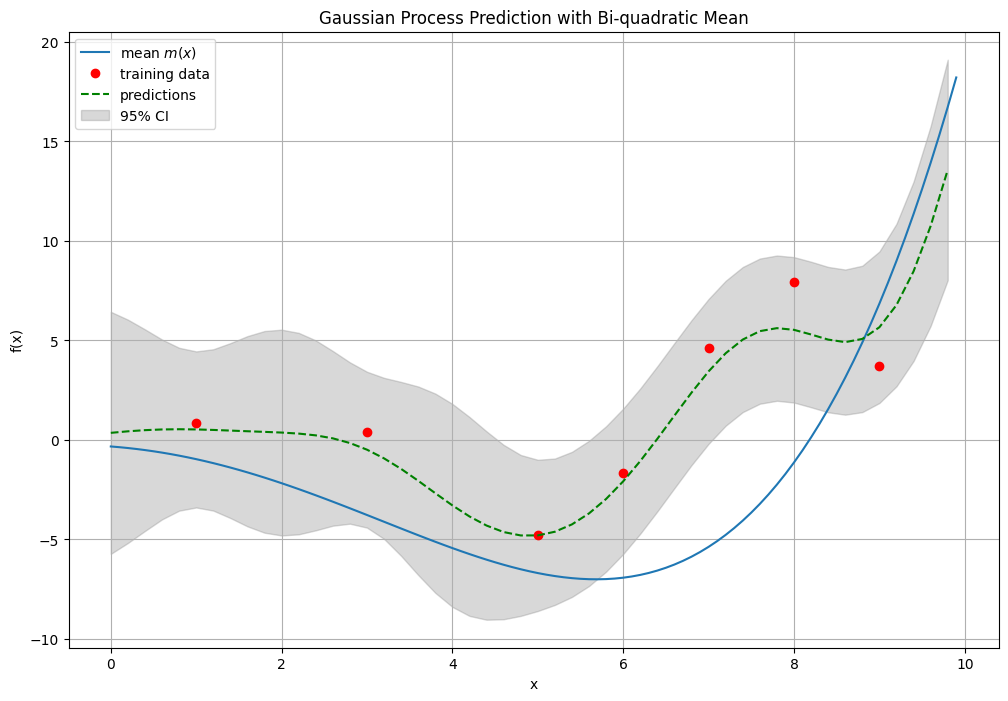

In [2]:
xB=np.array([1., 3., 5., 6., 7., 8., 9.])
yB=xB*np.sin(xB)
xPred, yPred, stds = gpr_predict(xB, yB, plot=True)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cobyla

def gpr_predict_multidim(XB, yB, XPred=None, plot=True):
    XB = np.atleast_2d(XB)
    n_samples, n_features = XB.shape

    # Normalização de entrada
    X_mean = XB.mean(axis=0)
    X_std = XB.std(axis=0)
    XB_scaled = (XB - X_mean) / X_std

    # Centralizar saída
    y_mean = yB.mean()
    y_centered = yB - y_mean

    # Normalizar XPred
    if XPred is not None:
        XPred = np.atleast_2d(XPred)
        XPred_scaled = (XPred - X_mean) / X_std
    else:
        x1 = np.linspace(-2, 2, 50)
        x2 = np.linspace(-2, 2, 50)
        X1, X2 = np.meshgrid(x1, x2)
        XPred_scaled = np.column_stack([X1.ravel(), X2.ravel()])

    # Média linear + constante
    def priormean(Xin, w, b):
        return Xin @ w + b

    # Kernel RBF isotrópico
    def corrFunc(xa, xb, sigmaF2, ell):
        return sigmaF2**2 * np.exp(-np.sum((xa - xb)**2) / (2.0 * ell**2))

    # Função objetivo (log-verossimilhança negativa)
    def objective(x):
        w = x[:n_features]
        b = x[n_features]
        sigmaF2 = x[n_features + 1]
        ell = x[n_features + 2]
        sigmaN2 = x[n_features + 3]
        mxB = priormean(XB_scaled, w, b)
        KB = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(i, n_samples):
                k = corrFunc(XB_scaled[i], XB_scaled[j], sigmaF2, ell)
                if i == j:
                    k += sigmaN2**2 + 1e-8  # jitter
                KB[i, j] = KB[j, i] = k
        KBinv = np.linalg.inv(KB)
        return -1 * (-0.5 * np.log(np.linalg.det(KB)) -
                     0.5 * (y_centered - mxB).T @ KBinv @ (y_centered - mxB) -
                     n_samples / 2 * np.log(2 * np.pi))

    # Restrições
    cons = [
        lambda x: x[n_features + 2] - 1,     # ell > 1
        lambda x: 5 - x[n_features + 2],     # ell < 5
        lambda x: x[n_features + 1] - 0.8    # sigmaF2 > 0.8
    ]

    # Inicialização
    x0 = np.ones(n_features + 4) * 0.1
    x0[n_features + 1] = 2.0   # sigmaF2
    x0[n_features + 2] = 1.0   # ell
    x0[n_features + 3] = 0.1   # sigmaN2

    xopt = fmin_cobyla(objective, x0, cons, disp=0)

    # Hiperparâmetros otimizados
    w = xopt[:n_features]
    b = xopt[n_features]
    sigmaF2 = xopt[n_features + 1]
    ell = xopt[n_features + 2]
    sigmaN2 = xopt[n_features + 3]

    # Matriz de covariância treino
    mxB = priormean(XB_scaled, w, b)
    KB = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i, n_samples):
            k = corrFunc(XB_scaled[i], XB_scaled[j], sigmaF2, ell)
            if i == j:
                k += sigmaN2**2 + 1e-8
            KB[i, j] = KB[j, i] = k
    KBinv = np.linalg.inv(KB)

    # Covariância cruzada
    Ks = np.array([[corrFunc(xp, xb, sigmaF2, ell) for xb in XB_scaled] for xp in XPred_scaled])
    mus = priormean(XPred_scaled, w, b)

    # Predição
    ypred_centered = mus + Ks @ KBinv @ (y_centered)
    ypred = ypred_centered + y_mean

    # Variância da predição
    Kss = np.array([
        [corrFunc(XPred_scaled[i], XPred_scaled[j], sigmaF2, ell) + (sigmaN2**2 if i == j else 0)
         for j in range(len(XPred_scaled))] for i in range(len(XPred_scaled))
    ])
    yvar = np.diag(Kss - Ks @ KBinv @ Ks.T)
    stds = np.sqrt(np.maximum(yvar, 0))

    # Visualização (apenas 2D)
    if plot and n_features == 2:
        x1 = XPred_scaled[:, 0].reshape(50, 50)
        x2 = XPred_scaled[:, 1].reshape(50, 50)
        ypred_grid = ypred.reshape(50, 50)
        plt.figure(figsize=(10, 8))
        plt.contourf(x1, x2, ypred_grid, cmap='viridis')
        plt.colorbar(label='Prediction')
        plt.scatter(XB_scaled[:, 0], XB_scaled[:, 1], c=yB, edgecolors='k', cmap='viridis', label="Training")
        plt.title("Gaussian Process Regression (2D)")
        plt.xlabel("x₁")
        plt.ylabel("x₂")
        plt.legend()
        plt.show()

    return XPred, ypred, stds


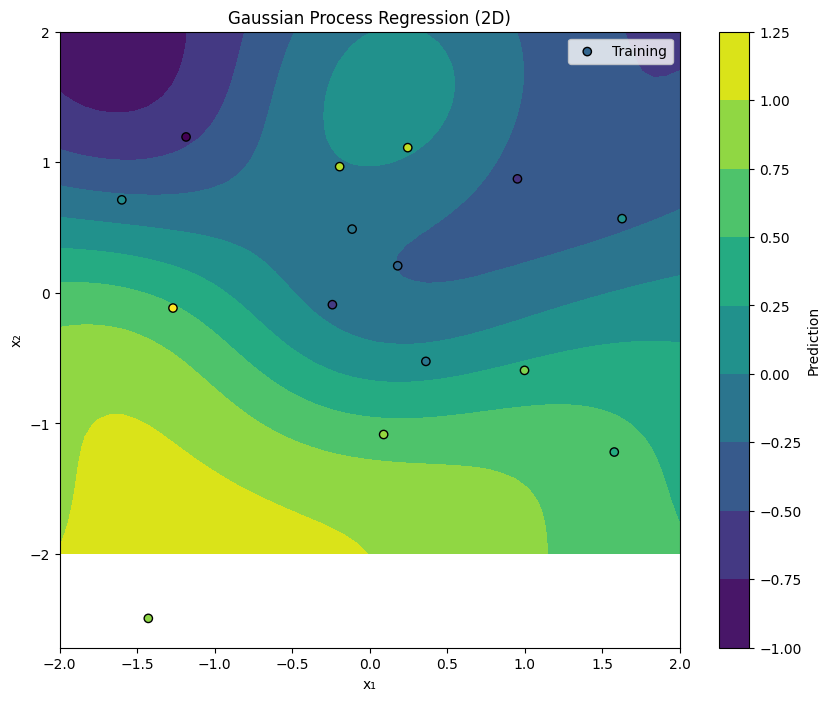

In [4]:
import numpy as np

# Cria dados de treino 2D: 15 pontos aleatórios no intervalo [0, 10]
np.random.seed(0)
XB = np.random.uniform(0, 10, (15, 2))

# Função alvo: sin(x1) * cos(x2) + ruído
yB = np.sin(XB[:, 0]) * np.cos(XB[:, 1])  + 0.1 * np.random.randn(15)
XPred, ypred, stds = gpr_predict_multidim(XB, yB, plot=True)

In [5]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

# Carregar os dados
co2 = fetch_openml(data_id=41187, as_frame=True)
df = co2.frame[['year', 'month', 'day', 'co2']].copy()

# Melhorar formatação
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df[['date', 'co2']].sort_values('date')

# Fazer média mensal
df = df.resample('M', on='date').mean().dropna().reset_index()

C:\Users\rezio\AppData\Local\Temp\ipykernel_17996\581774682.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M', on='date').mean().dropna().reset_index()


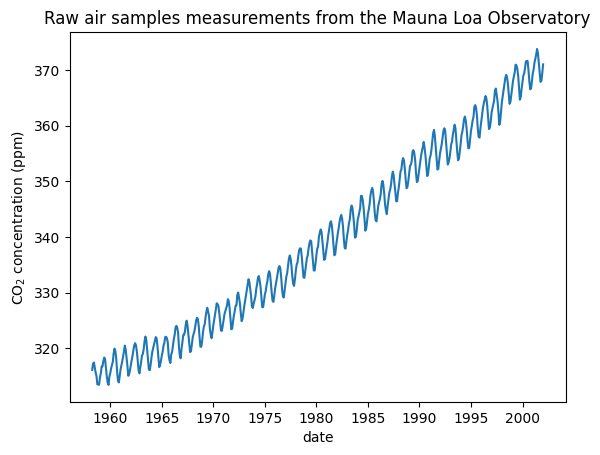

In [6]:
import matplotlib.pyplot as plt

plt.plot(df["date"], df["co2"])
plt.xlabel("date")
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")

In [7]:
# Meses como fração do ano
X = (df['date'].dt.year + df['date'].dt.month / 12).to_numpy().reshape(-1, 1)
y = df['co2'].to_numpy()

# Média para reposição
y_mean = y.mean()
y_centered = y - y_mean

In [8]:
import datetime

# Montar XPred de 1958 até ano atual + mês
today = datetime.datetime.now()
XPred = np.linspace(start=X.min(), stop=today.year + today.month / 12, num=500).reshape(-1,1)

In [9]:
Xpred_out, ypred_centered, stds = gpr_predict_multidim(X, y_centered, XPred=XPred, plot=False)

C:\Users\rezio\AppData\Local\Temp\ipykernel_17996\3120119261.py:52: RuntimeWarning: divide by zero encountered in log
  return -1 * (-0.5 * np.log(np.linalg.det(KB)) -


In [10]:
ypred = ypred_centered + y_mean

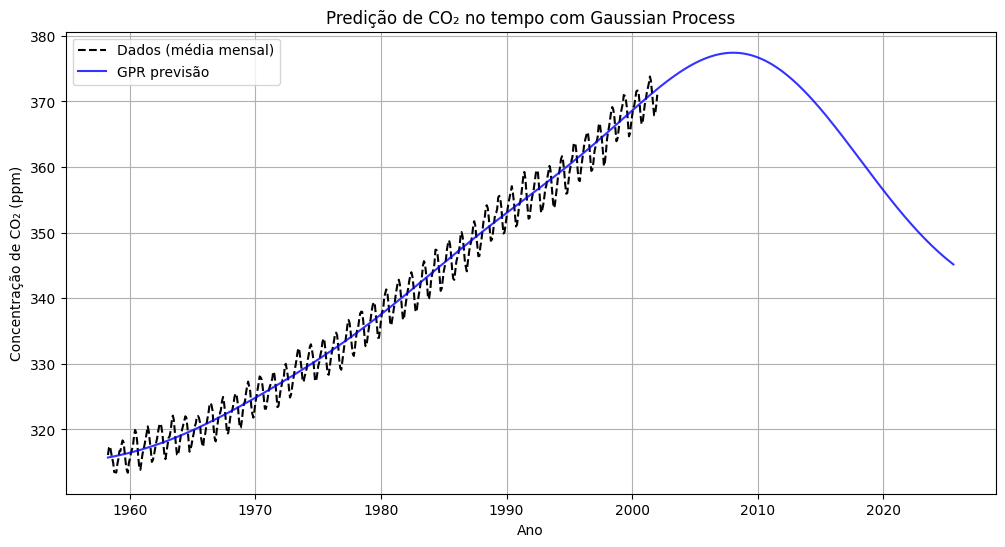

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(X, y, 'k--', label='Dados (média mensal)')
plt.plot(Xpred_out, ypred, 'b', alpha=0.8, label='GPR previsão')
plt.xlabel('Ano')
plt.ylabel('Concentração de CO₂ (ppm)')
plt.title('Predição de CO₂ no tempo com Gaussian Process')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cobyla

def gpr_predict_multidim(XB, yB, XPred=None, plot=True, kernel_func=None, mean_func=None):
    XB = np.atleast_2d(XB)
    n_samples, n_features = XB.shape

    # Normalização de entrada
    X_mean = XB.mean(axis=0)
    X_std = XB.std(axis=0)
    XB_scaled = (XB - X_mean) / X_std

    # Centralizar saída
    y_mean = yB.mean()
    y_centered = yB - y_mean

    # Normalizar XPred
    if XPred is not None:
        XPred = np.atleast_2d(XPred)
        XPred_scaled = (XPred - X_mean) / X_std
    else:
        x1 = np.linspace(-2, 2, 50)
        x2 = np.linspace(-2, 2, 50)
        X1, X2 = np.meshgrid(x1, x2)
        XPred_scaled = np.column_stack([X1.ravel(), X2.ravel()])

    # Função de média padrão: linear + constante
    if mean_func is None:
        def mean_func(Xin, w, b):
            return Xin @ w + b

    # Kernel padrão: RBF isotrópico
    if kernel_func is None:
        def kernel_func(xa, xb, sigmaF2, ell):
            return sigmaF2**2 * np.exp(-np.sum((xa - xb)**2) / (2.0 * ell**2))

    # Função objetivo (log-verossimilhança negativa)
    def objective(x):
        w = x[:n_features]
        b = x[n_features]
        sigmaF2 = x[n_features + 1]
        ell = x[n_features + 2]
        sigmaN2 = x[n_features + 3]
        mxB = mean_func(XB_scaled, w, b)
        KB = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(i, n_samples):
                k = kernel_func(XB_scaled[i], XB_scaled[j], sigmaF2, ell)
                if i == j:
                    k += sigmaN2**2 + 1e-8
                KB[i, j] = KB[j, i] = k
        KBinv = np.linalg.inv(KB)
        return -1 * (-0.5 * np.log(np.linalg.det(KB)) -
                     0.5 * (y_centered - mxB).T @ KBinv @ (y_centered - mxB) -
                     n_samples / 2 * np.log(2 * np.pi))

    # Restrições
    cons = [
        lambda x: x[n_features + 2] - 1,     # ell > 1
        lambda x: 5 - x[n_features + 2],     # ell < 5
        lambda x: x[n_features + 1] - 0.8    # sigmaF2 > 0.8
    ]

    # Inicialização
    x0 = np.ones(n_features + 4) * 0.1
    x0[n_features + 1] = 2.0   # sigmaF2
    x0[n_features + 2] = 1.0   # ell
    x0[n_features + 3] = 0.1   # sigmaN2

    xopt = fmin_cobyla(objective, x0, cons, disp=0)

    # Hiperparâmetros otimizados
    w = xopt[:n_features]
    b = xopt[n_features]
    sigmaF2 = xopt[n_features + 1]
    ell = xopt[n_features + 2]
    sigmaN2 = xopt[n_features + 3]

    # Matriz de covariância treino
    mxB = mean_func(XB_scaled, w, b)
    KB = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i, n_samples):
            k = kernel_func(XB_scaled[i], XB_scaled[j], sigmaF2, ell)
            if i == j:
                k += sigmaN2**2 + 1e-8
            KB[i, j] = KB[j, i] = k
    KBinv = np.linalg.inv(KB)

    # Covariância cruzada
    Ks = np.array([[kernel_func(xp, xb, sigmaF2, ell) for xb in XB_scaled] for xp in XPred_scaled])
    mus = mean_func(XPred_scaled, w, b)

    # Predição
    ypred_centered = mus + Ks @ KBinv @ (y_centered)
    ypred = ypred_centered + y_mean

    # Variância da predição
    Kss = np.array([
        [kernel_func(XPred_scaled[i], XPred_scaled[j], sigmaF2, ell) + (sigmaN2**2 if i == j else 0)
         for j in range(len(XPred_scaled))] for i in range(len(XPred_scaled))
    ])
    yvar = np.diag(Kss - Ks @ KBinv @ Ks.T)
    stds = np.sqrt(np.maximum(yvar, 0))

    # Visualização (apenas 2D)
    if plot and n_features == 2:
        x1 = XPred_scaled[:, 0].reshape(50, 50)
        x2 = XPred_scaled[:, 1].reshape(50, 50)
        ypred_grid = ypred.reshape(50, 50)
        plt.figure(figsize=(10, 8))
        plt.contourf(x1, x2, ypred_grid, cmap='viridis')
        plt.colorbar(label='Prediction')
        plt.scatter(XB_scaled[:, 0], XB_scaled[:, 1], c=yB, edgecolors='k', cmap='viridis', label="Training")
        plt.title("Gaussian Process Regression (2D)")
        plt.xlabel("x₁")
        plt.ylabel("x₂")
        plt.legend()
        plt.show()

    return XPred, ypred, stds


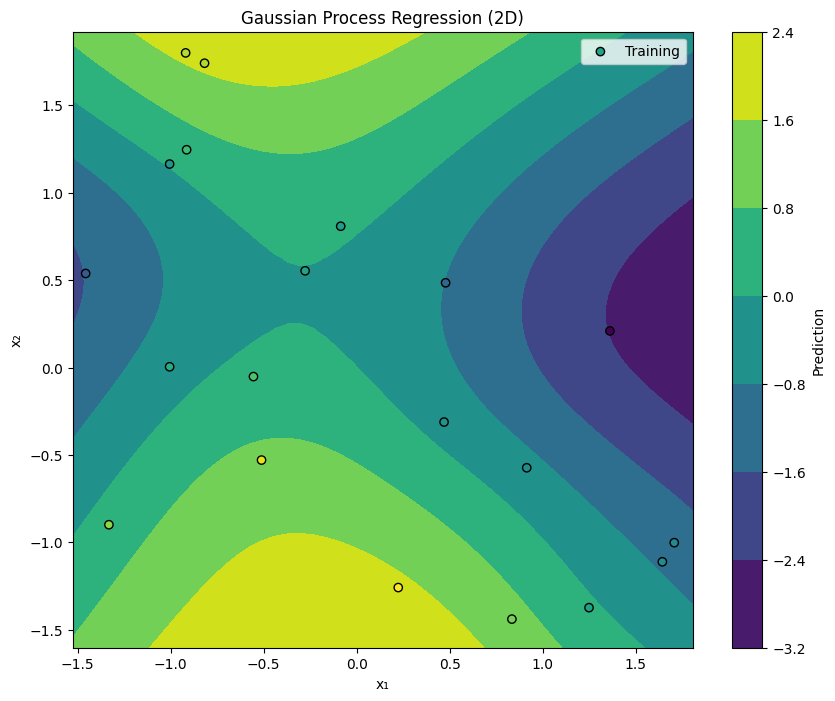

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Gerar dados de treino 2D
np.random.seed(42)
X1 = np.random.uniform(0, 5, 20)
X2 = np.random.uniform(0, 5, 20)
XB = np.column_stack([X1, X2])
yB = np.sin(X1) + np.cos(X2) + 0.1 * np.random.randn(20)  # função com ruído

# Gerar malha de predição 2D
x1_grid = np.linspace(0, 5, 50)
x2_grid = np.linspace(0, 5, 50)
X1g, X2g = np.meshgrid(x1_grid, x2_grid)
XPred = np.column_stack([X1g.ravel(), X2g.ravel()])

# Definir kernel Matérn 3/2 customizado
def matern32(xa, xb, sigmaF2, ell):
    r = np.linalg.norm(xa - xb)
    sqrt3 = np.sqrt(3) * r / ell
    return sigmaF2**2 * (1 + sqrt3) * np.exp(-sqrt3)

# Kernel Matérn 3/2 customizado
def matern32(xa, xb, sigmaF2, ell):
    r = np.linalg.norm(xa - xb)
    sqrt3 = np.sqrt(3) * r / ell
    return sigmaF2**2 * (1 + sqrt3) * np.exp(-sqrt3)

# Função de média polinomial quadrática
def quadratic_mean(X, w, b):
    return (X**2) @ w + b

# Chamada
XPred, ypred, stds = gpr_predict_multidim(XB, yB, XPred=XPred, kernel_func=matern32, mean_func=quadratic_mean)


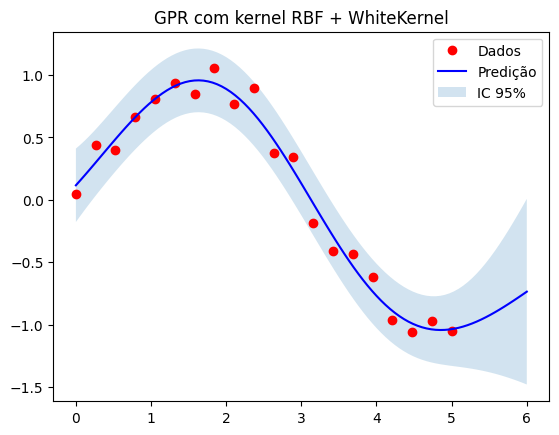

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import numpy as np
import matplotlib.pyplot as plt

# Dados sintéticos
X = np.linspace(0, 5, 20).reshape(-1, 1)
y = np.sin(X).ravel() + 0.1 * np.random.randn(20)

# Kernel: RBF + ruído branco
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)

# Modelo
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X, y)

# Predição
X_pred = np.linspace(0, 6, 100).reshape(-1, 1)
y_pred, std = gpr.predict(X_pred, return_std=True)

# Plot
plt.figure()
plt.plot(X, y, 'or', label="Dados")
plt.plot(X_pred, y_pred, 'b-', label="Predição")
plt.fill_between(X_pred.ravel(), y_pred - 2*std, y_pred + 2*std, alpha=0.2, label="IC 95%")
plt.legend()
plt.title("GPR com kernel RBF + WhiteKernel")
plt.show()


c:\Users\rezio\OneDrive\Documentos\.git codes\parepy\ambiente_parepy\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


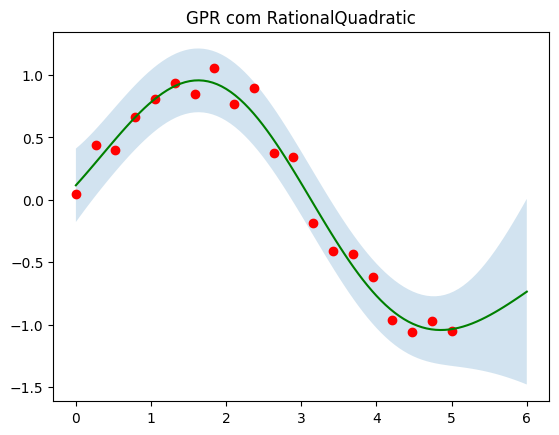

In [4]:
from sklearn.gaussian_process.kernels import RationalQuadratic

# Kernel: Racional Quadrático + ruído
kernel = RationalQuadratic(length_scale=1.0, alpha=0.5) + WhiteKernel(noise_level=0.1)

gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X, y)

y_pred, std = gpr.predict(X_pred, return_std=True)

plt.figure()
plt.plot(X, y, 'or')
plt.plot(X_pred, y_pred, 'g-')
plt.fill_between(X_pred.ravel(), y_pred - 2*std, y_pred + 2*std, alpha=0.2)
plt.title("GPR com RationalQuadratic")
plt.show()


In [ ]:
from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
X, y = load_iris(return_X_y=True)
kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X, y)
gpc.score(X, y)
gpc.predict_proba(X[:2,:])